#### Value at Risk (VaR) Analysis using the Monte Carlo Method for a portfolio of stocks using Python.
By running Monte Carlo simulations, we estimate the potential loss in our portfolio over a specified number of days and at a given confidence level. This information can be invaluable for investors and portfolio managers when assessing the risk associated with their investment decisions.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
### Set time from to a certain number of years
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)

### Create a list of tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [3]:
### Download the daily adjusted close prices for the tickers

adj_close_df = pd.DataFrame(yf.download(tickers, start=startDate, end=endDate)['Adj Close'])

print(adj_close_df)


[*********************100%***********************]  5 of 5 completed

Ticker                           BND         GLD         QQQ         SPY  \
Date                                                                       
2009-09-25 00:00:00+00:00  51.741100   97.000000   36.472595   79.126694   
2009-09-28 00:00:00+00:00  51.767109   97.050003   37.093567   80.543312   
2009-09-29 00:00:00+00:00  51.767109   97.430000   36.927395   80.300873   
2009-09-30 00:00:00+00:00  51.767109   98.849998   36.953640   79.990303   
2009-10-01 00:00:00+00:00  52.000999   97.889999   35.860329   78.005486   
...                              ...         ...         ...         ...   
2024-09-16 00:00:00+00:00  75.639999  238.660004  473.239990  561.118896   
2024-09-17 00:00:00+00:00  75.540001  237.339996  473.489990  561.348206   
2024-09-18 00:00:00+00:00  75.309998  235.509995  471.440002  559.683350   
2024-09-19 00:00:00+00:00  75.309998  239.169998  483.359985  569.234009   
2024-09-20 00:00:00+00:00  75.300003  242.210007  482.440002  568.250000   

Ticker     

In [4]:
### Calculate the daily log returns and drop any NAs
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns  = log_returns.dropna()

print(log_returns)


Ticker                          BND       GLD       QQQ       SPY       VTI
Date                                                                       
2009-09-28 00:00:00+00:00  0.000503  0.000515  0.016882  0.017745  0.018545
2009-09-29 00:00:00+00:00  0.000000  0.003908 -0.004490 -0.003015 -0.001672
2009-09-30 00:00:00+00:00  0.000000  0.014469  0.000710 -0.003875 -0.003725
2009-10-01 00:00:00+00:00  0.004508 -0.009759 -0.030033 -0.025126 -0.026855
2009-10-02 00:00:00+00:00 -0.003019  0.004892 -0.002931 -0.004672 -0.005959
...                             ...       ...       ...       ...       ...
2024-09-16 00:00:00+00:00  0.002648 -0.000084 -0.004428  0.001476  0.001982
2024-09-17 00:00:00+00:00 -0.001323 -0.005546  0.000528  0.000409  0.001008
2024-09-18 00:00:00+00:00 -0.003049 -0.007740 -0.004339 -0.002970 -0.002521
2024-09-19 00:00:00+00:00  0.000000  0.015421  0.024970  0.016920  0.016804
2024-09-20 00:00:00+00:00 -0.000133  0.012631 -0.001905 -0.001730 -0.002094

[3771 rows 

In [5]:
### Create a function that will be used to calculate portfolio expected return
#We are assuming that future returns are based on past returns, which is not a reliable assumption.
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

### Create a function that will be used to calculate portfolio standard deviation
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [6]:
### Create a covariance matrix for all the securities
cov_matrix = log_returns.cov()
print(cov_matrix)


Ticker           BND       GLD           QQQ           SPY           VTI
Ticker                                                                  
BND     9.227903e-06  0.000009  8.431183e-07 -1.744754e-08  1.683293e-07
GLD     8.880801e-06  0.000097  7.759850e-06  6.638513e-06  7.237875e-06
QQQ     8.431183e-07  0.000008  1.665185e-04  1.295548e-04  1.323297e-04
SPY    -1.744754e-08  0.000007  1.295548e-04  1.169458e-04  1.193911e-04
VTI     1.683293e-07  0.000007  1.323297e-04  1.193911e-04  1.228686e-04


In [7]:
### Create an equally weighted portfolio and find total portfolio expected return and standard deviation
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation (weights, cov_matrix)

In [8]:
def random_z_score():
    return np.random.normal(0, 1)

### Create a function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [9]:
### Run 10000 simulations
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [10]:
### Specify a confidence interval and calculate the Value at Risk (VaR)
confidence_interval = 0.99
VaR = np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)


-68275.63518408286


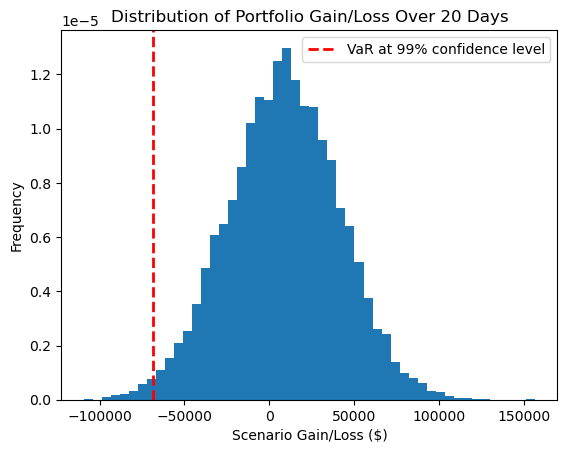

In [11]:
### Plot the results of all 10000 scenarios
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()


In [12]:
# Calculate CVaR
def calculate_CVaR(scenarioReturn, VaR, confidence_interval):
    losses_below_var = [x for x in scenarioReturn if x <= VaR]
    CVaR = np.mean(losses_below_var)
    return CVaR


CVaR = calculate_CVaR(scenarioReturn, VaR, confidence_interval)
print(f'CVaR at {confidence_interval:.0%} confidence level: ${CVaR:,.2f}')

CVaR at 99% confidence level: $-78,550.82


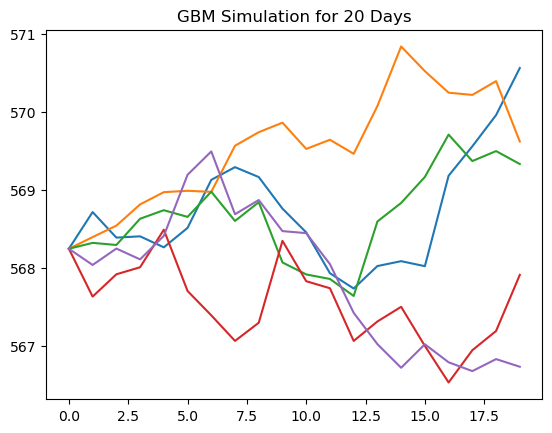

In [13]:
# Geometric Brownian Motion (GBM) Simulation
def simulate_gbm(initial_value, mu, sigma, days, simulations):
    dt = 1 / 252  # Year of 252 days
    random_walk = np.random.normal(0, 1, (days, simulations))
    price_paths = np.zeros_like(random_walk)
    price_paths[0] = initial_value

    for t in range(1, days):
        price_paths[t] = price_paths[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * random_walk[t])

    return price_paths

# Example of a GBM simulation for SPY
initial_value = adj_close_df['SPY'].iloc[-1]
mu = log_returns['SPY'].mean()
sigma = log_returns['SPY'].std()
days = 20
simulations = 10000

gbm_simulations = simulate_gbm(initial_value, mu, sigma, days, simulations)

# Plot of GBM simulations
plt.plot(gbm_simulations[:, :5])  # PLot of some GBM simulated
plt.title(f'GBM Simulation for {days} Days')
plt.show()

C:\Users\Pierre Pro\AppData\Local\Temp\ipykernel_5372\2619281481.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_paths[i, t] = price_paths[i, t-1] * np.exp((log_returns.mean()[i] - 0.5 * log_returns.std()[i]**2) * dt + log_returns.std()[i] * np.sqrt(dt) * correlated_random_walk[i])


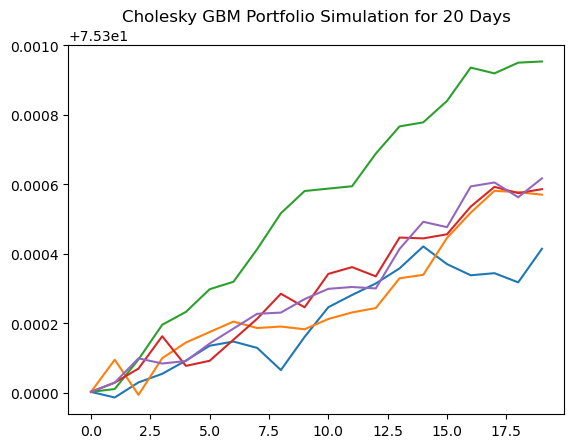

In [14]:
# Cholesky decomposition to simulate a portfolio
def simulate_portfolio_gbm_cholesky(log_returns, cov_matrix, initial_value, days, simulations):
    dt = 1 / 252
    chol_decomp = np.linalg.cholesky(cov_matrix)
    random_walks = np.random.normal(0, 1, (len(log_returns.columns), days, simulations))
    price_paths = np.zeros_like(random_walks)

    for i, ticker in enumerate(log_returns.columns):
        price_paths[i, 0] = initial_value[i]  # Initialisation avec les valeurs actuelles

    for t in range(1, days):
        correlated_random_walk = chol_decomp @ random_walks[:, t, :]
        for i, ticker in enumerate(log_returns.columns):
            price_paths[i, t] = price_paths[i, t-1] * np.exp((log_returns.mean()[i] - 0.5 * log_returns.std()[i]**2) * dt + log_returns.std()[i] * np.sqrt(dt) * correlated_random_walk[i])

    return price_paths

# Simulation for the entire portfolio
initial_values = adj_close_df.iloc[-1].values
cov_matrix = log_returns.cov().values

portfolio_simulations = simulate_portfolio_gbm_cholesky(log_returns, cov_matrix, initial_values, days, simulations)

# Plot of some simulated paths of the portfolio
plt.plot(portfolio_simulations[0, :, :5])  # Plot for the first ticker of the portfolio
plt.title(f'Cholesky GBM Portfolio Simulation for {days} Days')
plt.show()